# Topic modelling 

# Data Preprocess

In [40]:
#pip install pyldavis


In [1]:
import numpy as np
import pandas as pd 

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
data = pd.read_csv('all_participants.csv')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

data

,Participant
0,"Yes, thank you, Uli. The good thing is that I ..."
1,Three quick questions. One is just a follow-up...
2,"Well, good afternoon to everybody here in Lond..."
3,"Well, thank you very much. We will now begin w..."


In [5]:
data_tim = pd.read_csv('/Users/matheusmaciel/CASS/MSc 2021-22 /ARP /data_collecting/paragraph_split_df.csv')
data_tim

,text,participants
0,"Good morning, ladies and gentlemen. I welcome ...",Operator
1,"Well, good morning, everyone and welcome to ou...",Jean-Jacques Henchoz
2,"Thank you very much, Clemens. On the next slid...",Jean-Jacques Henchoz
3,"(Question And Answer)Ladies and gentlemen, we ...",Operator
4,"Hi. Good morning, everyone. Could I just dig i...",Andrew Ritchie
...,...,...
60,Yes. Two quick questions. The first one would ...,Thomas Fossard
61,"And on the NatCat, so as Jean-Jacques explaine...",Klaus Miller
62,Thank you. Thank you.,Thomas Fossard
63,And there are no further questions at this poi...,Operator


In [6]:
def lemmatization(texts, allowed_postags=["NOUN"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []

    for row in range(len(data_tim)):
        for text in texts:
            doc = nlp(data_tim.loc[row,"text"])
        
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

lemmatized_texts = lemmatization(data_tim)
lemmatized_texts[0]
#lemmatized_texts

'morning lady gentleman today re information conference isbeing time call host today sir'

In [45]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])

['morning', 'lady', 'gentleman', 'today', 're', 'information', 'conference', 'isbeing', 'time', 'call', 'host', 'today', 'sir']


In [46]:
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

print (corpus[0][0:20])

word = id2word[[0][:1][0]]
print (word)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2)]
call


### TF IDF 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [9]:
vectoriser = TfidfVectorizer(
    lowercase=True,
    max_features=100,
    max_df=0.8, 
    min_df=5,
    ngram_range=(1,3),
    stop_words= "english"
)

vectors = vectoriser.fit_transform(lemmatized_texts)

feature_names = vectoriser.get_feature_names()

dense = vectors.todense()
denselist = dense.tolist()


In [10]:
all_keywords = []

for description in denselist:
    x=0
    keywords = []
    for word in description:
        if word > 0:
            keywords.append(feature_names[x])
        x=x+1
    all_keywords.append(keywords)

print (all_keywords[0])


['information', 'morning', 'time', 'today']


In [11]:
true_k = 20

model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)

model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectoriser.get_feature_names()


In [13]:
with open ("data/trc_results.txt", "w", encoding="utf-8") as f:
    for i in range(true_k):
        f.write(f"Cluster {i}")
        f.write("\n")
        for ind in order_centroids[i, :10]:
            f.write (' %s' % terms[ind],)
            f.write("\n")
        f.write("\n")
        f.write("\n")


FileNotFoundError: [Errno 2] No such file or directory: 'data/trc_results.txt'

# LDA 

In [47]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

## WiP - Coherence Values 

In [48]:
#LDA topic modeling
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 100);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);


In [55]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=lemmatized_texts, start=2, limit=20, step=6)

/Users/matheusmaciel/opt/anaconda3/envs/nlp_env/lib/python3.8/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:202: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
/Users/matheusmaciel/opt/anaconda3/envs/nlp_env/lib/python3.8/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:203: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
/Users/matheusmaciel/opt/anaconda3/envs/nlp_env/lib/python3.8/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:198: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs


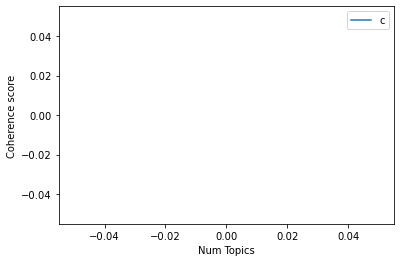

In [56]:
# Show graph
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Results - table

In [51]:
topic_df = get_lda_topics(lda_model, 10)

In [58]:
topic_df

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,year,mortality,question,year,number,year,growth,year,longevity,loss
1,pension,result,year,life,view,growth,question,loss,life,year
2,business,side,business,cover,rate,business,line,growth,growth,premium
3,number,claim,number,number,increase,calculation,loss,quarter,claim,number
4,lot,year,effect,mortality,year,thank,year,effect,ratio,underwriting
...,...,...,...,...,...,...,...,...,...,...
95,client,quitedifficult,pandemic,way,income,target,accounting,flood,weeksand,income
96,gain,in,issuance,information,range,bond,view,highlight,retro,people
97,return,recalculation,high,thanif,term,date,target,depreciation,loss,equity
98,ratio,idea,volatility,difference,slide,cash,return,provision,income,expectation


## Visualising data and topics

In [52]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/Users/matheusmaciel/opt/anaconda3/envs/nlp_env/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/matheusmaciel/opt/anaconda3/envs/nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/matheusmaciel/opt/anaconda3/envs/nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/matheusmaciel/opt/anaconda3/envs/nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.156394  0.076919       1        1  40.738032
1      0.077219  0.182104       2        1   9.630690
6     -0.186003  0.040933       3        1   8.863274
2     -0.097839  0.154218       4        1   8.145028
8      0.087242 -0.109473       5        1   6.941361
5     -0.020811  0.081567       6        1   6.049699
9     -0.029312 -0.216985       7        1   5.945457
0     -0.136866 -0.112911       8        1   5.443894
4     -0.007785 -0.041083       9        1   4.742897
3      0.157761 -0.055288      10        1   3.499667, topic_info=          Term       Freq      Total Category  logprob  loglift
121       loss  43.000000  43.000000  Default  30.0000  30.0000
91      growth  45.000000  45.000000  Default  29.0000  29.0000
235       year  63.000000  63.000000  Default  28.0000  28.0000
271   question  27.000000  27.000000  Default  27.0000  27.0000
136  mortality  21.000000  21.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
271   question   0.596030  27.049294  Topic10  -4.7119  -0.4626
172    quarter   0.592868  23.190212  Topic10  -4.7173  -0.3140
166    premium   0.590157  11.779596  Topic10  -4.7218   0.3588
151    outlook   0.589935   5.745509  Topic10  -4.7222   1.0763
58       digit   0.589194   6.089269  Topic10  -4.7235   1.0170

[566 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
532       5  0.720413         accident
13        1  0.156834          account
13        2  0.156834          account
13        5  0.156834          account
13        6  0.156834          account
...     ...       ...              ...
235       8  0.078950             year
235       9  0.031580             year
235      10  0.047370             year
441       2  0.688318  yourexpectation
539       5  0.720416     yourquestion

[713 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 7, 3, 9, 6, 10, 1, 5, 4])

Initial attempt at LDA topic modelling using 4 sample texts from earnings calls 

**ToDo**
- clean text to better categorise topics 

source: https://github.com/wjbmattingly/topic_modeling_textbook/blob/main/03_03_lda_model_demo.ipynb